
# Optimal Transport Conformal Prediction
Conformal Prediction (CP) quantifies uncertainty in machine learning by creating prediction sets based on conformity scores. While it traditionally works with single-value scores, extending it to vector-valued settings is tricky because there's no natural way to order vectors. This tutorial introduces Optimal Transport Conformal Prediction (OTCP), a method that uses optimal transport to rank multivariate scores while maintaining confidence guarantees. 

Given a dataset
$
D_n = \{(x_1, y_1), ..., (x_n, y_n)\} \text{ and a new input } x_{n+1},
$
the goal is to create a set that includes the true response $y_{n+1}$ with a confidence level of $100(1-\alpha)\%$.
This involves:
1. Calculating scores $S(x, y, \hat y)$ (e.g., prediction errors) for each observation $(x, y)$ in $D_n$.
2. Ranking these scores.
3. For the new input $x_{n+1}$, including all possible responses $y$ whose score $S(x_{n+1}, y, \hat y)$ is small enough compared to the scores in $D_n$.

The challenge is that ranking multivariate scores $S(x, y, \hat y) \in \mathbb{R}^d$ (where $d \geq 2$) isn't straightforward, unlike univariate scores in $\mathbb{R}$. Classical CP relies on the canonical ranking of the real line, which cannot be directly applied to vector-valued scores. OTCP solves this by using optimal transport to define a meaningful ranking.
We use a discrete transport map $T$ to align the multivariate scores with a uniform distribution. This map minimizes the "cost" of transforming the empirical distribution of scores into a uniform distribution. The score function is redefined using optimal transport:
     $$
     S_{\rm{OT-CP}}(x, y) = \|T^\star \circ S(x, y)\|,
     $$
     where $T^\star$ is the optimal transport map. This reduces multivariate scores to a single dimension, enabling the application of standard CP methods.
OTCP extends CP to multivariate settings, enabling its use in tasks with multi-output predictions (e.g., predicting multiple labels or regression targets). It ensures confidence guarantees while remaining interpretable.
We'll explore practical implementations and code examples to demonstrate how OTCP can be applied to real-world machine learning problems.

More details are available in our paper

> Michal Klein, Louis Bethune, Eugene Ndiaye, and Marco Cuturi.  
> *Multivariate Conformal Prediction using Optimal Transport*.  
> [arXiv:2502.03609](https://arxiv.org/abs/2502.03609), 2025.  


In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt
import seaborn as sns

from ott.tools.conformal import OTCP

# Select a base model

In [2]:
random_state = 414
# skl_model = RandomForestRegressor()
skl_model = MLPRegressor(
    hidden_layer_sizes=(500,),
    learning_rate_init=0.0001,
    max_iter=2000,
    learning_rate="adaptive",
)

# Dataset Information and Summary statistics

We will use Taxi Data that are the taxi trip records of New York City which include the pickup, drop-off locations of each trip and the corresponding time. We use the pickup time and location as covariates $X$ to predict drop-off locations $Y$. The locations are
represented by latitudes and longitudes.

Similar data was used in (https://arxiv.org/pdf/2206.06584, https://arxiv.org/pdf/2501.10533)

In [3]:
data_url = "https://raw.githubusercontent.com/Vekteur/multi-output-conformal-regression/refs/heads/master/data/wang/taxi.csv"
df = pd.read_csv(data_url)

display(df.head())

,pickup_loc_lat,pickup_loc_lon,pickup_time_day_of_week_sin,pickup_time_day_of_week_cos,pickup_time_of_day_sin,pickup_time_of_day_cos,dropoff_loc_lat,dropoff_loc_lonor
0,-73.980118,40.743050,-0.866025,-0.653644,0.0,1.0,-73.913490,40.763142
1,-73.994057,40.719990,-0.866025,-0.653644,0.0,1.0,-73.966362,40.789871
2,-73.979424,40.744614,-0.866025,-0.653644,0.0,1.0,-73.992035,40.753944
3,-73.998344,40.723896,-0.866025,-0.653644,0.0,1.0,-73.995850,40.688400
4,-74.006149,40.744919,-0.866025,-0.653644,0.0,1.0,-73.993797,40.741440


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61286 entries, 0 to 61285
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   pickup_loc_lat               61286 non-null  float64
 1   pickup_loc_lon               61286 non-null  float64
 2   pickup_time_day_of_week_sin  61286 non-null  float64
 3   pickup_time_day_of_week_cos  61286 non-null  float64
 4   pickup_time_of_day_sin       61286 non-null  float64
 5   pickup_time_of_day_cos       61286 non-null  float64
 6   dropoff_loc_lat              61286 non-null  float64
 7   dropoff_loc_lonor            61286 non-null  float64
dtypes: float64(8)
memory usage: 3.7 MB


In [5]:
display(df.describe())

,pickup_loc_lat,pickup_loc_lon,pickup_time_day_of_week_sin,pickup_time_day_of_week_cos,pickup_time_of_day_sin,pickup_time_of_day_cos,dropoff_loc_lat,dropoff_loc_lonor
count,61286.000000,61286.000000,61286.000000,61286.000000,61286.000000,61286.000000,61286.000000,61286.000000
mean,-73.975390,40.747536,-0.865771,-0.147786,0.421956,0.552753,-73.967296,40.749312
std,0.036560,0.029253,0.014840,0.467545,0.339860,0.633184,0.038659,0.035973
min,-74.034904,40.620636,-0.866025,-0.653644,-0.866025,-1.000000,-74.039680,40.620003
25%,-73.992500,40.731281,-0.866025,-0.653644,0.126199,0.378649,-73.990540,40.730484
50%,-73.984459,40.748840,-0.866025,0.283662,0.288196,0.894934,-73.977913,40.750820
75%,-73.968849,40.764542,-0.866025,0.283662,0.746057,0.984041,-73.954470,40.769855
max,-73.752846,40.859047,0.000000,1.000000,1.000000,1.000000,-73.750069,40.859982


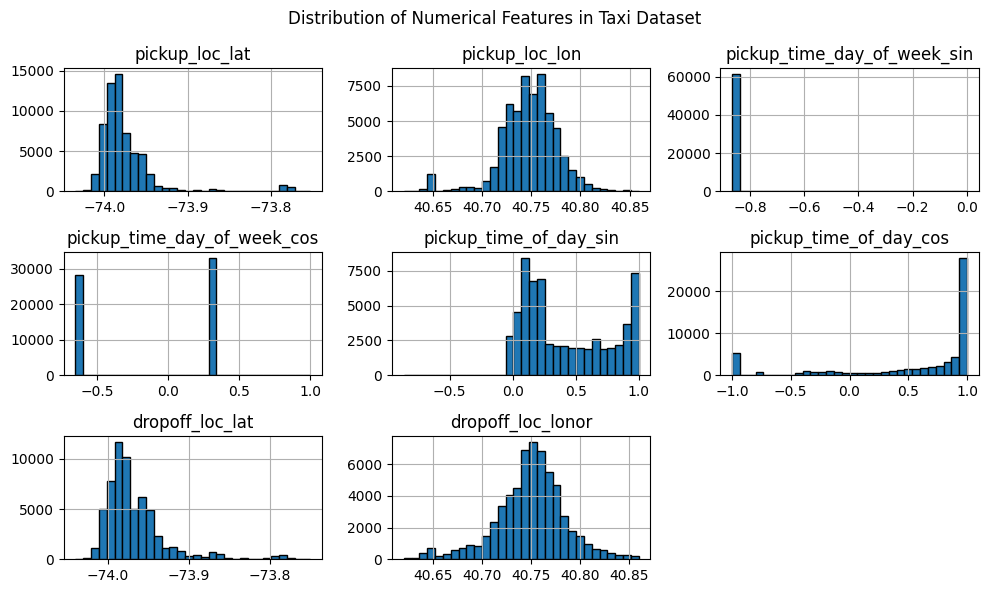

In [6]:
df.hist(figsize=(10, 6), bins=30, edgecolor="black")
plt.suptitle("Distribution of Numerical Features in Taxi Dataset")
plt.tight_layout()
plt.show()

In [7]:
print("Column names in the dataset:")
print(df.columns)

df.rename(columns={"dropoff_loc_lonor": "dropoff_loc_lon"}, inplace=True)
print(df.columns)

Column names in the dataset:
Index(['pickup_loc_lat', 'pickup_loc_lon', 'pickup_time_day_of_week_sin',
       'pickup_time_day_of_week_cos', 'pickup_time_of_day_sin',
       'pickup_time_of_day_cos', 'dropoff_loc_lat', 'dropoff_loc_lonor'],
      dtype='object')
Index(['pickup_loc_lat', 'pickup_loc_lon', 'pickup_time_day_of_week_sin',
       'pickup_time_day_of_week_cos', 'pickup_time_of_day_sin',
       'pickup_time_of_day_cos', 'dropoff_loc_lat', 'dropoff_loc_lon'],
      dtype='object')


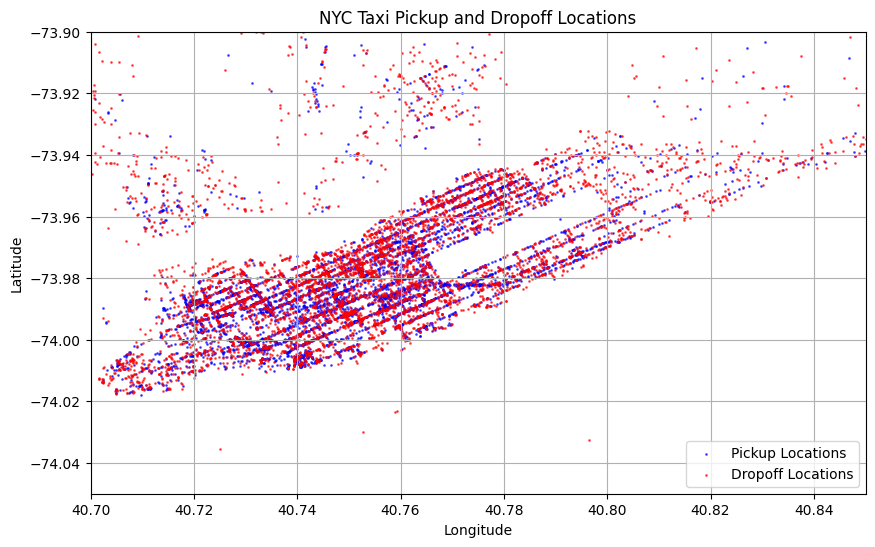

In [8]:
sample_fraction = 0.1
df_sampled = df.sample(frac=sample_fraction, random_state=random_state)

plt.figure(figsize=(10, 6))
plt.scatter(
    df_sampled["pickup_loc_lon"],
    df_sampled["pickup_loc_lat"],
    s=1,
    alpha=0.6,
    label="Pickup Locations",
    color="blue",
)
plt.scatter(
    df_sampled["dropoff_loc_lon"],
    df_sampled["dropoff_loc_lat"],
    s=1,
    alpha=0.6,
    label="Dropoff Locations",
    color="red",
)

plt.xlim(40.7, 40.85)
plt.ylim(-74.05, -73.9)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("NYC Taxi Pickup and Dropoff Locations")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
sampled_df = df.sample(n=10000, random_state=42)
train_df, test_df = train_test_split(
    sampled_df, test_size=0.22, random_state=random_state
)
train_df, calib_df = train_test_split(
    train_df, test_size=0.20, random_state=random_state
)

X_train = train_df[["pickup_loc_lat", "pickup_loc_lon"]].to_numpy()
Y_train = train_df[["dropoff_loc_lat", "dropoff_loc_lon"]].to_numpy()

X_calib = calib_df[["pickup_loc_lat", "pickup_loc_lon"]].to_numpy()
Y_calib = calib_df[["dropoff_loc_lat", "dropoff_loc_lon"]].to_numpy()

X_test = test_df[["pickup_loc_lat", "pickup_loc_lon"]].to_numpy()
Y_test = test_df[["dropoff_loc_lat", "dropoff_loc_lon"]].to_numpy()

In [10]:
skl_model.fit(X_train, Y_train)


def model(x):
    return jax.pure_callback(skl_model.predict, jnp.zeros_like(x), x)


otcp = OTCP(model=model)
otcp = otcp.fit_transport(jnp.array(X_train), jnp.array(Y_train), epsilon=0.1)
otcp = otcp.calibrate(jnp.array(X_calib), jnp.array(Y_calib))

In [11]:
# Confidence level
alpha = 0.1

The backward selected points are $\hat y(x) - T^{-1}(B(0, r_\alpha))$

[[-73.978004  40.752872]
 [-73.97834   40.752243]
 [-73.97822   40.75271 ]
 ...
 [-73.95653   40.786736]
 [-73.99698   40.73593 ]
 [-73.97817   40.752556]]


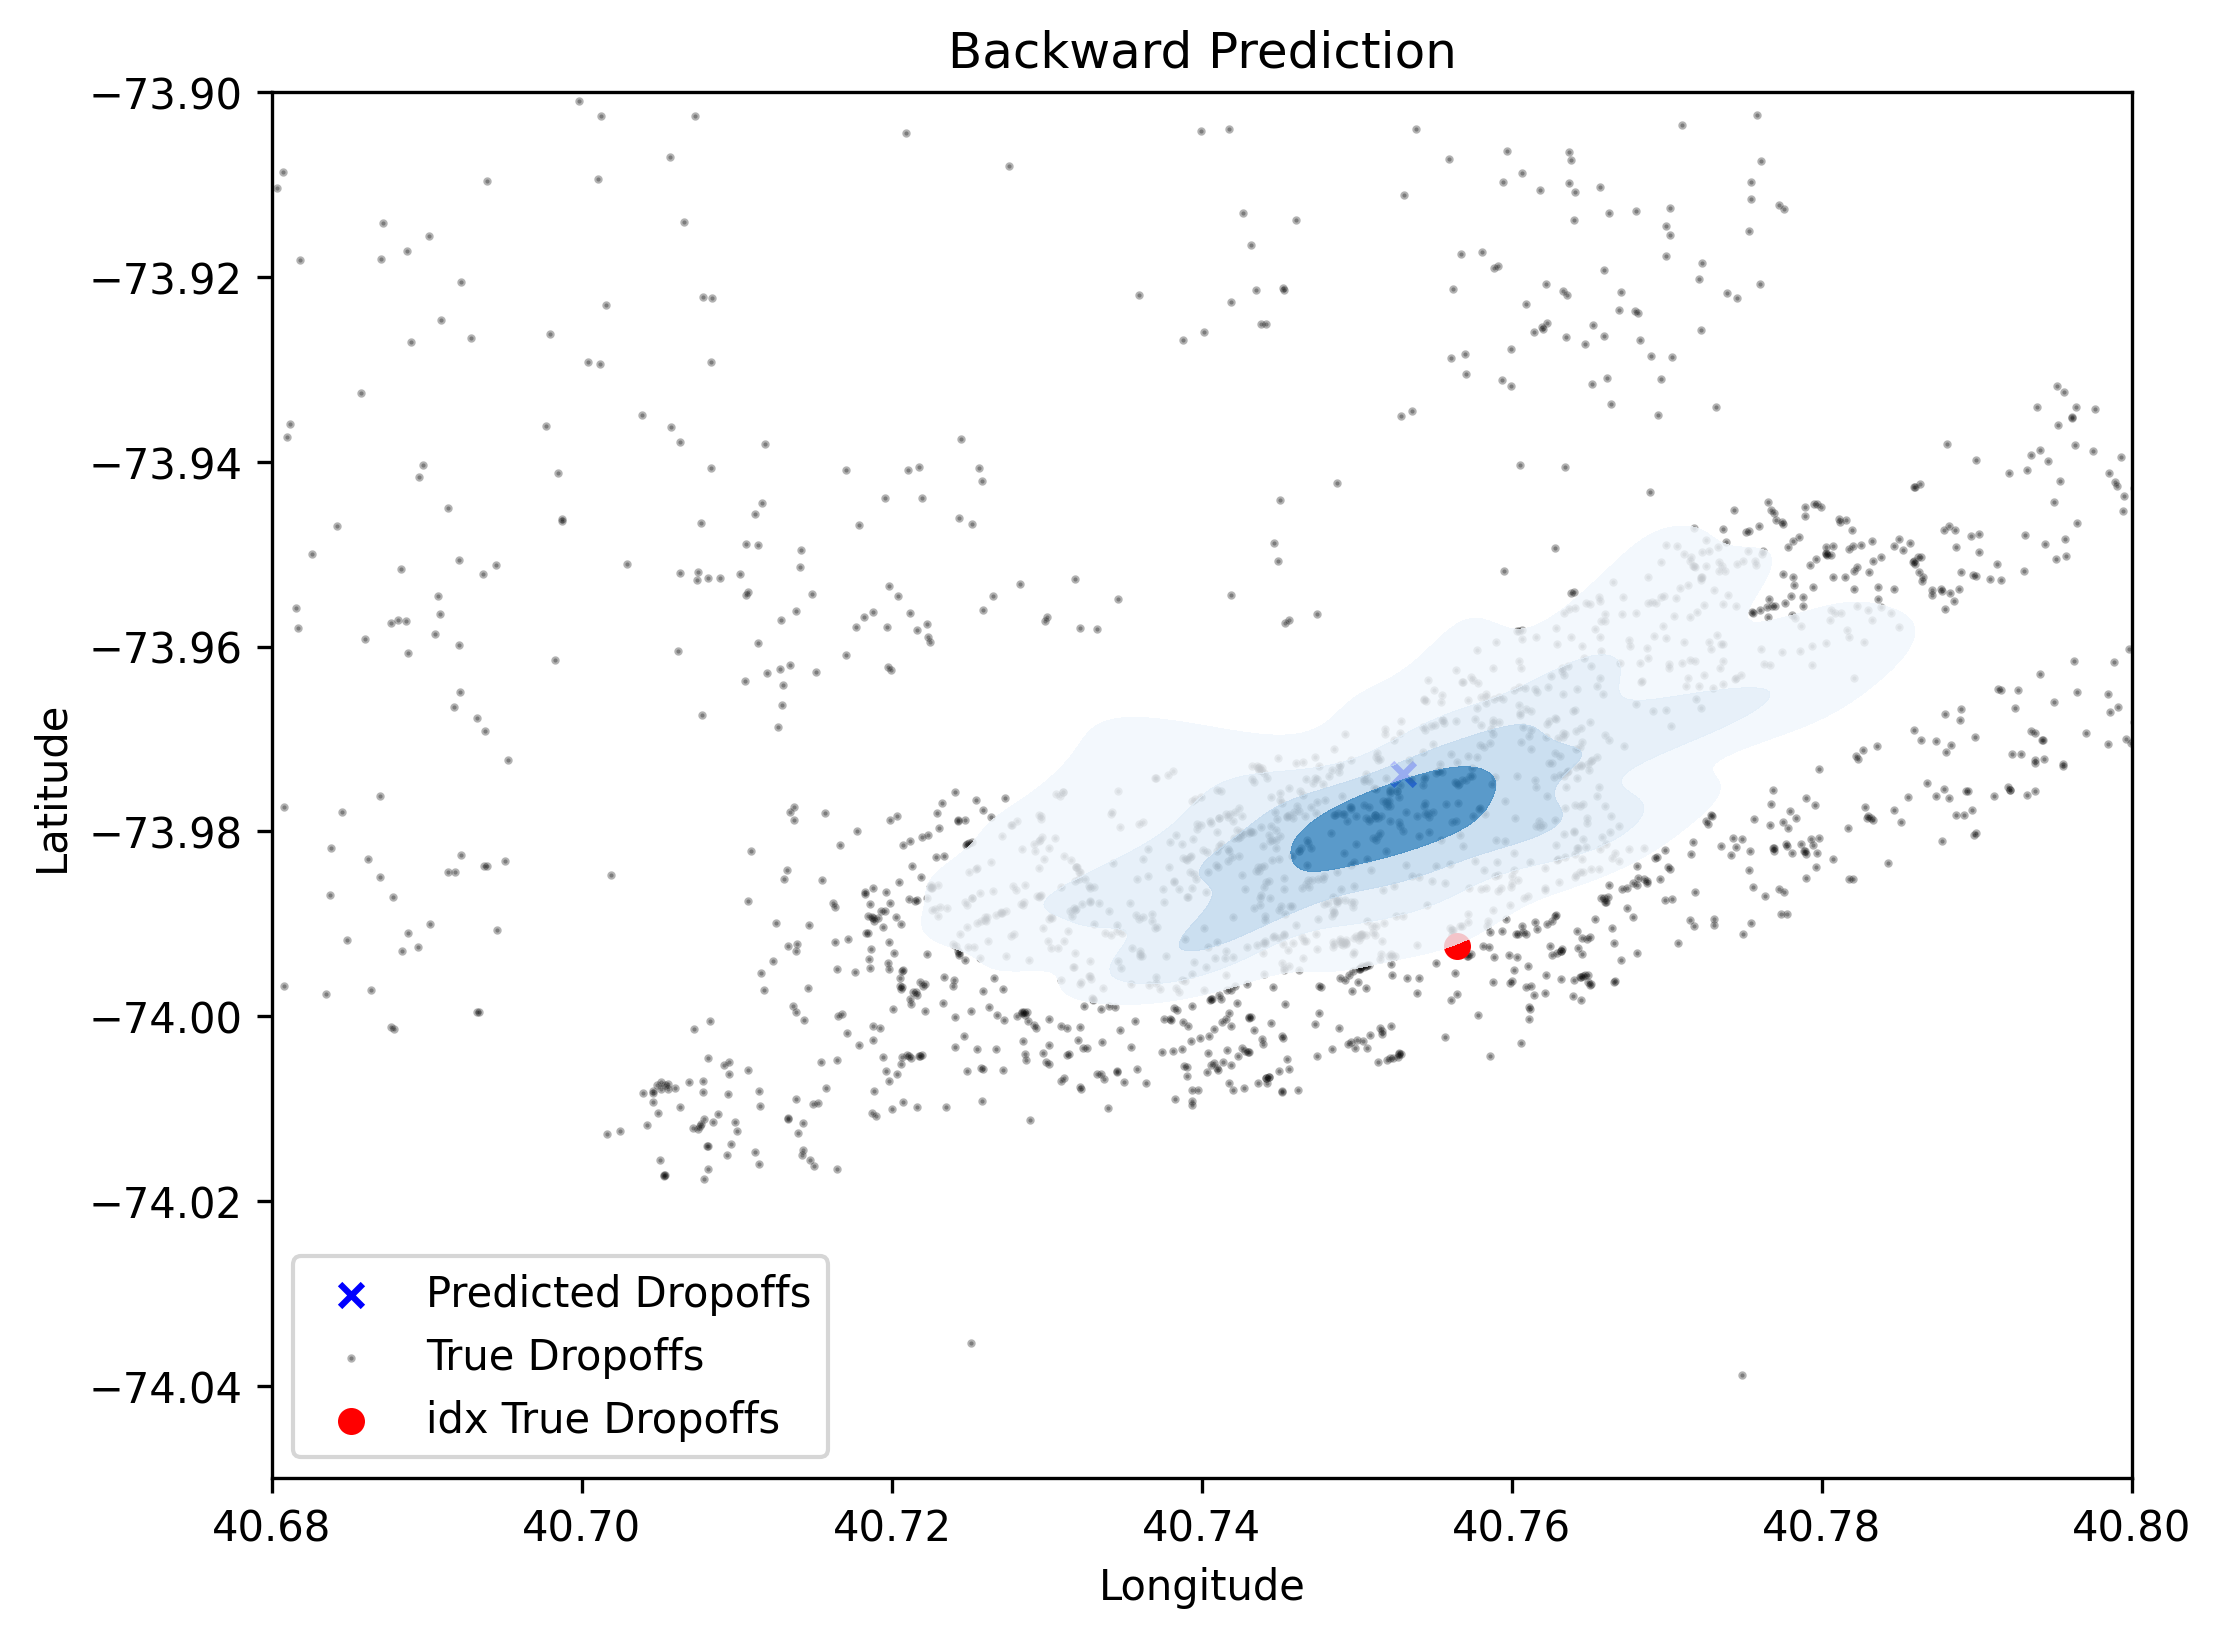

In [12]:
idx = [0]
Y_pred = skl_model.predict(X_test[idx]).ravel()
confidence_regions = otcp.predict(jnp.array(X_test[idx]), alpha=alpha)
print(confidence_regions[idx[0]])

fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
ax.scatter(
    Y_pred[1],
    Y_pred[0],
    s=30,
    color="blue",
    alpha=1,
    label="Predicted Dropoffs",
    marker="x",
)
ax.scatter(
    Y_test[:, 1],
    Y_test[:, 0],
    s=1,
    color="black",
    alpha=0.3,
    label="True Dropoffs",
)
ax.scatter(
    Y_test[idx, 1],
    Y_test[idx, 0],
    s=30,
    color="red",
    alpha=1,
    label="idx True Dropoffs",
)

sns.kdeplot(
    x=confidence_regions[idx, :, 1].flatten(),
    y=confidence_regions[idx, :, 0].flatten(),
    levels=5,
    fill=True,
    cmap="Blues",
    alpha=0.8,
    thresh=0.1,
    zorder=5,
    label="Contour of Confidence Region",
    legend=True,
)

ax.set_xlim(40.68, 40.8)
ax.set_ylim(-74.05, -73.9)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Backward Prediction")
plt.legend()
plt.show()

The forward selected points are $\{y: \|T(y - \hat y(x))\| \leq r_{\alpha}\}$

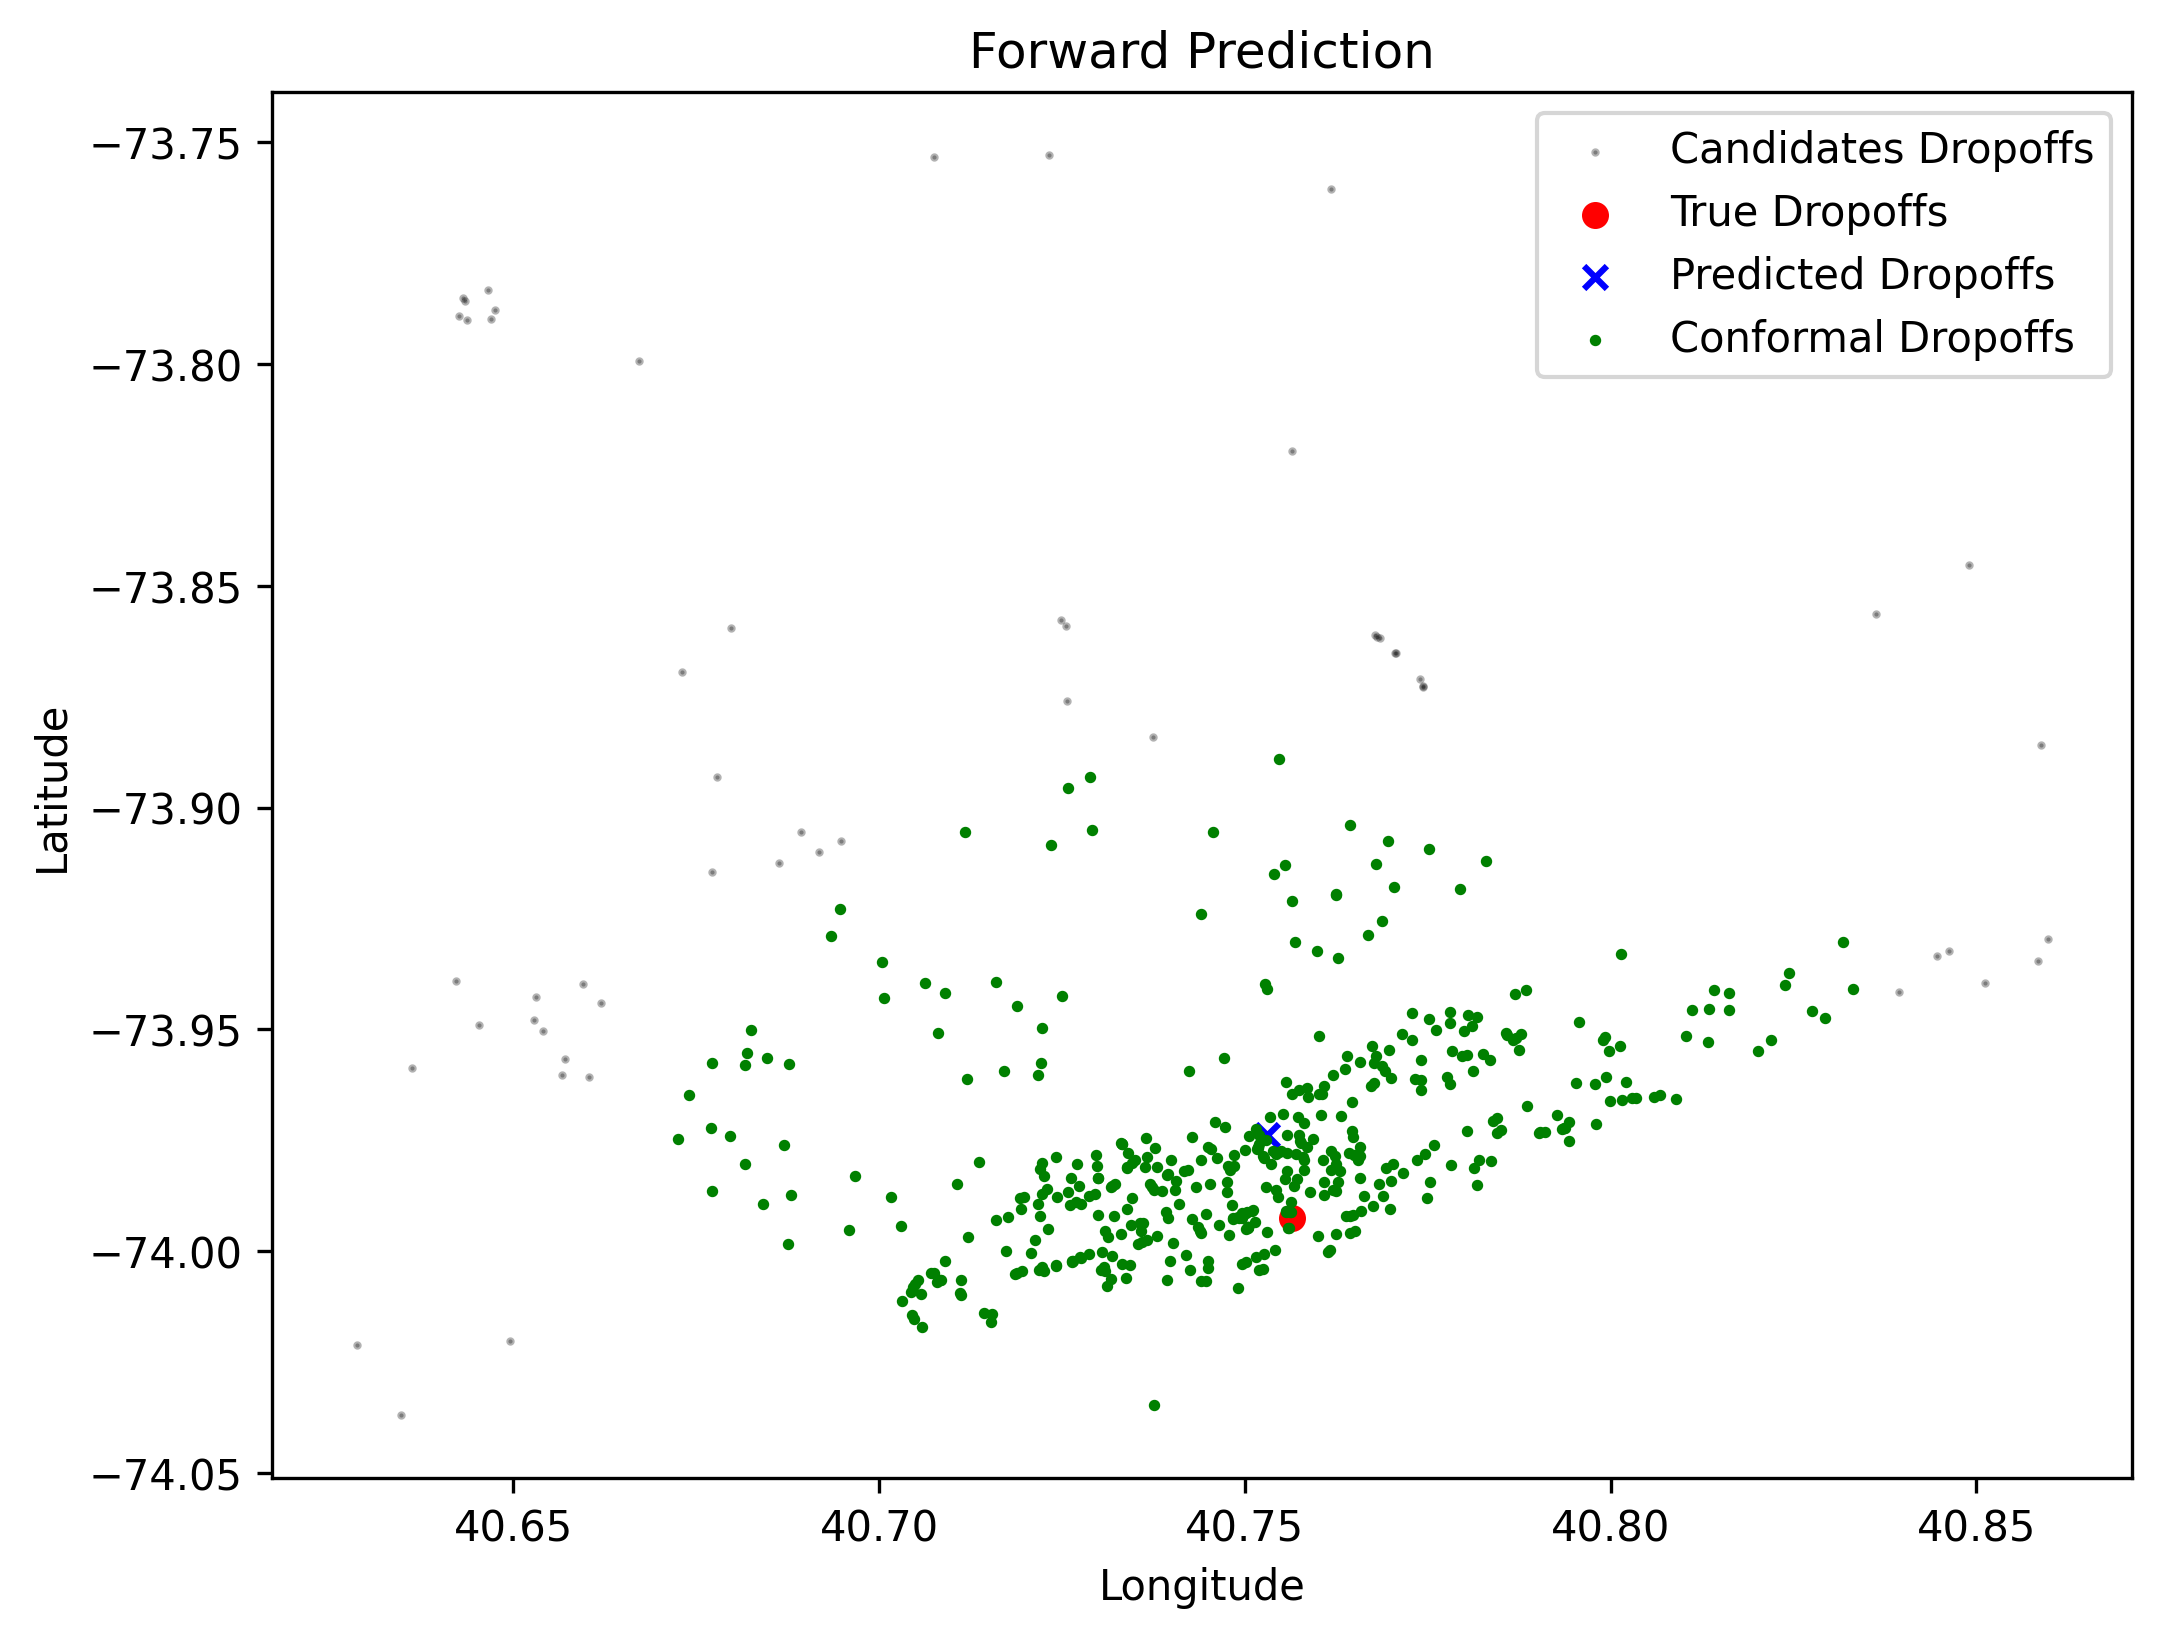

In [13]:
# Forward Prediction: filtered candidate dropoff points
idx = 0
y_candidates = jnp.array(Y_train[:500])
forward_mask = otcp.predict(
    jnp.array(X_test[idx]), y_candidates=y_candidates, alpha=alpha
)
conformal_candidates = y_candidates[forward_mask]
Y_pred = skl_model.predict(X_test[idx, None]).ravel()


fig, ax2 = plt.subplots(figsize=(8, 6), dpi=300)
ax2.scatter(
    y_candidates[:, 1],
    y_candidates[:, 0],
    s=1,
    color="black",
    alpha=0.3,
    label="Candidates Dropoffs",
)
ax2.scatter(
    Y_test[idx, 1],
    Y_test[idx, 0],
    s=30,
    color="red",
    alpha=1,
    label="True Dropoffs",
)
ax2.scatter(
    Y_pred[1],
    Y_pred[0],
    s=30,
    color="blue",
    alpha=1,
    label="Predicted Dropoffs",
    marker="x",
)
ax2.scatter(
    conformal_candidates[:, 1],
    conformal_candidates[:, 0],
    s=3,
    color="green",
    label="Conformal Dropoffs",
)
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_title("Forward Prediction")
ax2.legend()
plt.show()